In [7]:
import sys

python_path = ['/home/claudio/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages/opencv-4.1.0-py3.6.egg/cv2',
               '/home/sebastian/.local/lib/python3.6/site-packages/cv2','/home/sebastian/dat/onnx/onnx-tensorrt/third_party/onnx']
sys.path.extend(python_path)

print(sys.path)
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from PIL import ImageFile
from sklearn.cluster import KMeans
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import urllib
#import cv2
import os
import matplotlib.pyplot as plt
from matplotlib import patches
from torch.distributions import MultivariateNormal
from torch.nn import *
from torch import nn
ImageFile.LOAD_TRUNCATED_IMAGES = True

from attention_model import *

['/home/claudio/.virtualenvs/pytorch/lib64/python36.zip', '/home/claudio/.virtualenvs/pytorch/lib64/python3.6', '/home/claudio/.virtualenvs/pytorch/lib64/python3.6/lib-dynload', '/usr/lib64/python3.6', '/usr/lib/python3.6', '', '/home/claudio/.virtualenvs/pytorch/lib/python3.6/site-packages', '/home/claudio/.local/lib/python3.6/site-packages', '/home/claudio/.local/lib/python3.6/site-packages/opencv-4.1.0-py3.6.egg', '/home/claudio/.local/lib/python3.6/site-packages/gluoncv-0.5.0-py3.6.egg', '/usr/lib64/python3.6/site-packages', '/home/sebastian/.local/lib/python3.6/site-packages/tqdm-4.33.0-py3.6.egg', '/home/sebastian/dat/mxnet1.5.x/python', '/home/claudio/.virtualenvs/mxnet/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages/IPython/extensions', '/home/claudio/.ipython', '/home/claudio/.local/lib64/python3.6/site-packages', '/home/sebastian/.local/lib64/python3.6/site-packages', '/home/sebast

In [2]:
df = pd.read_pickle('tags_onehot_corrected.pkl')

In [3]:
df.columns

Index(['ballroom', 'bar_lounge', 'basics', 'bathroom', 'beach', 'breakfast',
       'business_center', 'city_view', 'exterior_view', 'golf_course',
       'guest_room', 'guest_room_amenities', 'health_club', 'hot_news',
       'hotel_front', 'interior_view', 'kitchen', 'living_room', 'lobby_view',
       'logo', 'map', 'meeting_room', 'miscellaneous', 'natural_view',
       'pool_view', 'promotional', 'property_amenities',
       'recreational_facility', 'restaurant', 'spa', 'suite', 'file'],
      dtype='object')

In [6]:
tags = df.columns.values

In [7]:
bathroom_df = df[df.bathroom == 1]

In [8]:
bathroom_indices = bathroom_df.index.values

In [9]:
bathroom_df.reset_index(inplace = True)

In [10]:
bathroom_bedroom = bathroom_df[bathroom_df.guest_room == 1].reset_index()

In [31]:
transform = transforms.Compose([transforms.Resize((450,450)), transforms.CenterCrop(448), transforms.ToTensor()])

In [18]:
features = torch.load('feature_maps.pt')

In [629]:
features.shape

torch.Size([36, 512, 14, 14])

In [78]:
feature_maps = features[bathroom_indices]

In [11]:
def get_max_activation_positions(feature_maps):
    feature_maps_plain = feature_maps.view(feature_maps.shape[0], feature_maps.shape[1], -1)
    max_feature_maps_plain = torch.argmax(feature_maps_plain, dim=2)
    y = max_feature_maps_plain / 14
    x = max_feature_maps_plain % 14
    
    return torch.stack([x,y], dim = 2)

In [80]:
max_points = get_max_activation_positions(feature_maps)

In [81]:
max_points.shape

torch.Size([2654, 512, 2])

In [12]:
def get_channel_clusters(max_activation_positions, num_clusters=4):
    channel_features = max_activation_positions.permute((1,0,2)).reshape(512,-1)
    kmeans = KMeans(n_clusters= num_clusters, random_state=0).fit(channel_features.detach().numpy())
    return torch.from_numpy(kmeans.predict(channel_features.detach().numpy()))

In [83]:
channel_groups = get_channel_clusters(max_points, num_clusters=5)

In [13]:
def build_feature_map_mask(channel_groups, group):
    return channel_groups == group

In [14]:
def get_attention_map(group, channel_groups, image_feature_map):
    mask = build_feature_map_mask(channel_groups,group).type(torch.float)
    return torch.sum(image_feature_map * mask.view(512,1,1), dim=0).view(1,14,14)

In [15]:
def get_attention_map_image(group, channel_groups, image_feature_map):
    att = get_attention_map(group, channel_groups, image_feature_map)
    min_value = torch.min(att)
    max_value = torch.max(att)
    att = att / torch.max(att)
    print(att.shape)
    gray_scale_att_image = Image.fromarray(np.uint8(att.detach().numpy()[0] * 255) , 'L').resize((448,448), Image.BILINEAR)
    heatmapimg = np.array(np.array(gray_scale_att_image), dtype = np.uint8)
    
    return Image.fromarray(cv2.applyColorMap(-heatmapimg, cv2.COLORMAP_JET))

In [32]:
to_image = transforms.Compose([transforms.ToPILImage(), transforms.Resize(448)])

In [33]:
image_file_name = '/home/ec2-user/rawImages/' + df.iloc[bathroom_indices[image_index]].file

NameError: name 'bathroom_indices' is not defined

In [89]:
def plot_heatmap_on_image(image_file_name, image_feature_map, channel_groups , group = 1):
    img = Image.open(image_file_name)
    img_tensor = transform(img)
    img = TF.to_pil_image(img_tensor)
    att_image = get_attention_map_image(group, channel_groups, image_feature_map)
    return Image.blend(img, att_image, 0.3)

In [90]:
def get_max_center(group, channel_groups, image_feature_map):
    att = get_attention_map(group, channel_groups, image_feature_map)
    att_max_index = torch.argmax(att).float()
    x_att_max = (att_max_index % 14) + 0.5
    y_att_max = (att_max_index // 14) + 0.5
    x_max = (x_att_max / 14) * 448
    y_max = (y_att_max / 14) * 448
    return x_max, y_max

In [91]:
x,y = get_max_center(0, channel_groups, image_feature_map)

NameError: name 'image_feature_map' is not defined

In [92]:
print('max is at (%s, %s)' % (x, y))

NameError: name 'x' is not defined

In [93]:
def plot_box_on_image(group, channel_groups, image_feature_map, w = 100, h = 100):
    x,y = get_max_center(group, channel_groups, image_feature_map)
    x = x - w/2
    y = y - h/2
    image = plot_heatmap_on_image(image_file_name, image_feature_map, channel_groups, group=group)
    fig, ax = plt.subplots()
    ax.imshow(image)
    rect = patches.Rectangle((x,y),w,h, edgecolor='b', facecolor="none")
    ax.add_patch(rect)

torch.Size([1, 14, 14])


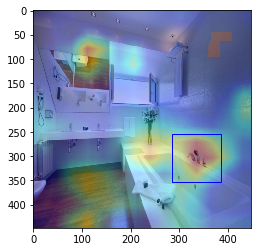

In [99]:
image_index = 16
image_feature_map = feature_maps[image_index]
image_file_name = '/home/ec2-user/rawImages/' + df.iloc[bathroom_indices[image_index]].file
plot_box_on_image(0, channel_groups, image_feature_map)

torch.Size([1, 14, 14])


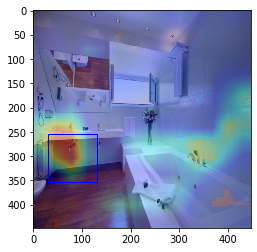

In [100]:
plot_box_on_image(1, channel_groups, image_feature_map)

torch.Size([1, 14, 14])


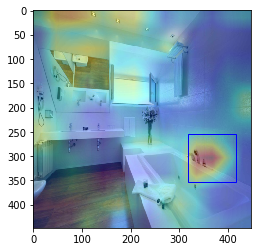

In [101]:
plot_box_on_image(2, channel_groups, image_feature_map)

torch.Size([1, 14, 14])


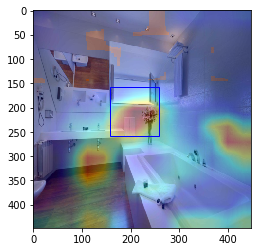

In [102]:
plot_box_on_image(3, channel_groups, image_feature_map)

torch.Size([1, 14, 14])


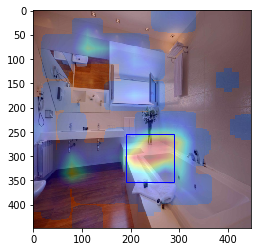

In [103]:
plot_box_on_image(4, channel_groups, image_feature_map)

## Some examples of clusterization on bird dataset

In [104]:
bird_features = torch.load('feature_maps_albatross.pt')

In [105]:
bird_features.shape

torch.Size([36, 512, 14, 14])

In [106]:
bird_max_activation = get_max_activation_positions(bird_features)

In [107]:
bird_channel_groups = get_channel_clusters(bird_max_activation, num_clusters=4)

In [108]:
path_bird_images = 'images/001.Black_footed_Albatross/'

In [109]:
bird_image_file_names = os.listdir(path_bird_images)

In [110]:
sample_index = 0
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


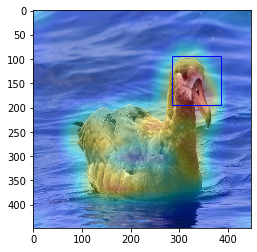

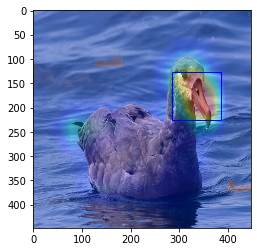

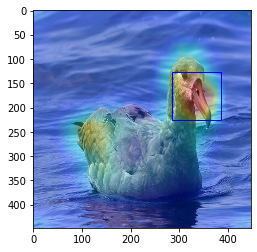

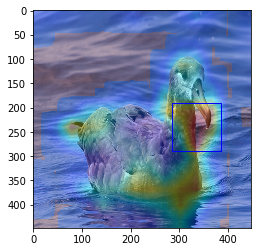

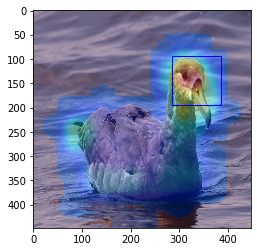

In [111]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [112]:
sample_index = 10
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


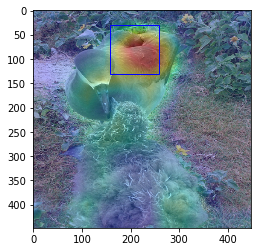

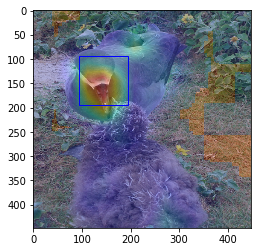

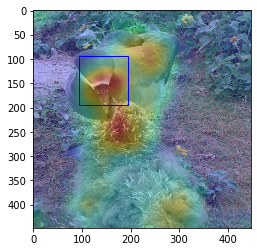

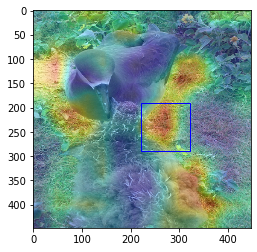

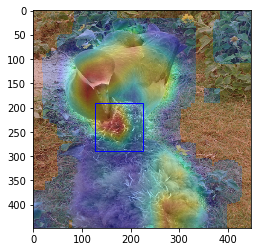

In [113]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [114]:
sample_index = 1
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


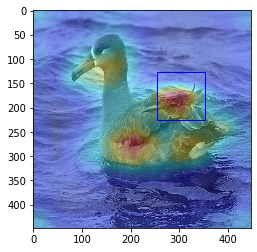

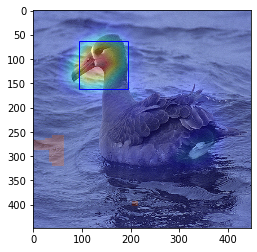

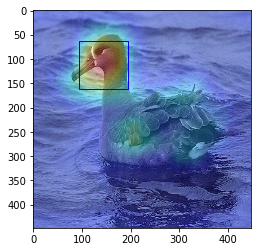

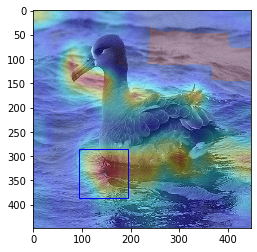

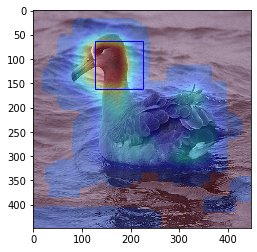

In [115]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [116]:
sample_index = 2
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


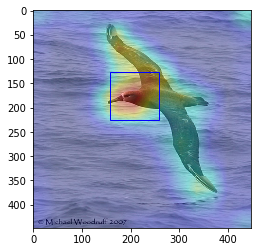

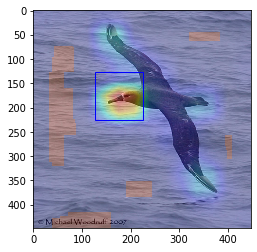

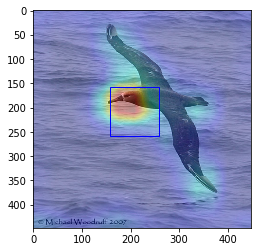

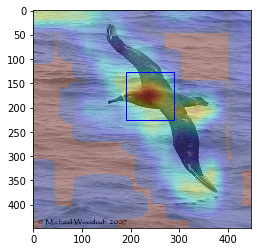

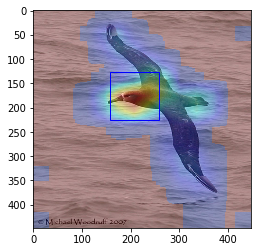

In [117]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [118]:
sample_index = 4
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


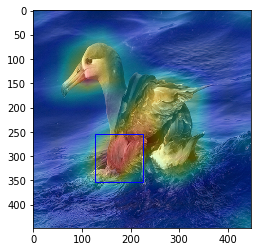

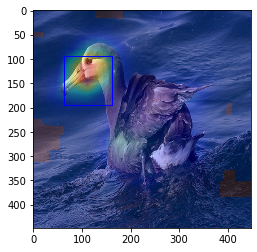

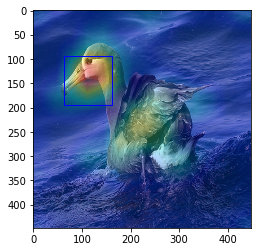

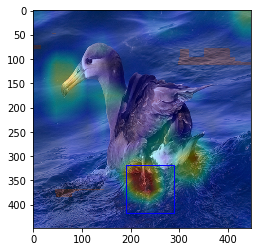

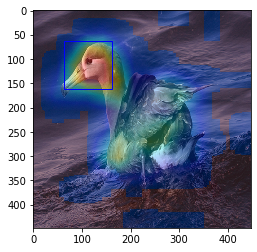

In [119]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [120]:
sample_index = 5
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


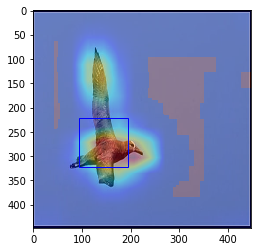

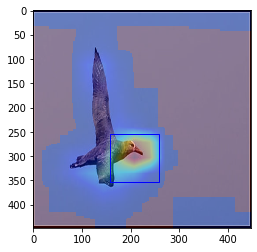

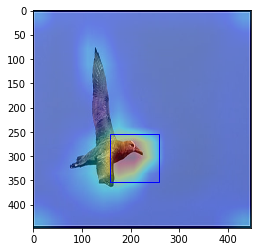

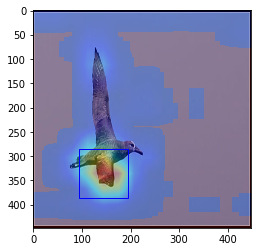

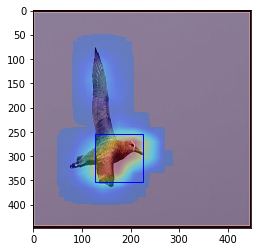

In [121]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [122]:
sample_index = 6
image_file_name = path_bird_images + bird_image_file_names[sample_index]
image_feature_map = bird_features[sample_index]

torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


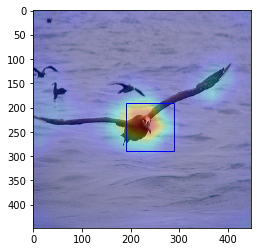

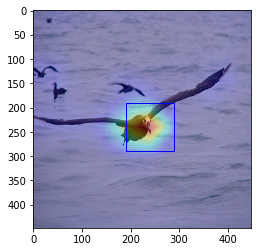

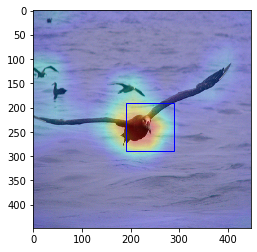

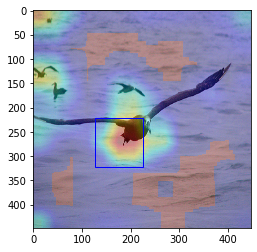

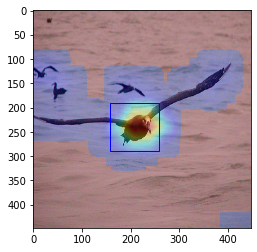

In [123]:
for i in range(5):
    plot_box_on_image(i, channel_groups, image_feature_map)

In [16]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [20]:
embeddings = F.avg_pool2d(features, 14)

In [21]:
embeddings = embeddings.view(embeddings.shape[0], -1)

In [22]:
labels = df.columns.values

In [23]:
kmeans = KMeans(n_clusters= 30, random_state=0, n_jobs=8).fit(embeddings)

In [24]:
groups = kmeans.predict(embeddings)

In [34]:
all_group_positions = []
all_group_attention_maps = []
all_group_attention_maps_normalized = []
all_feature_map_weights = []

indices_track = []

for group in range(30):
    print(group)
    indices = np.argwhere(groups == group).ravel()
    indices_track.extend(indices.tolist())
    feature_maps = features[indices]
    print(feature_maps.shape)
    max_activation_positions = get_max_activation_positions(feature_maps)
    channel_groups = get_channel_clusters(max_activation_positions, num_clusters=4)
    
    group_positions = torch.empty(4,indices.shape[0],2)
    group_attention_maps = torch.empty(4, indices.shape[0],14,14)
    group_attention_maps_normalized = torch.empty(4, indices.shape[0],14,14)
    feature_map_weights = torch.empty(4,indices.shape[0], 512)
    
    for group in range(4):
        mask = build_feature_map_mask(channel_groups,group).type(torch.float)
        feature_map_weights[group] = torch.stack([mask] * indices.shape[0])
        attention_maps = torch.sum(feature_maps * mask.view(512,1,1), dim=1)
        max_values, _ = torch.max(attention_maps.view(attention_maps.shape[0],-1), dim=1)
        attention_maps_normalized = attention_maps / max_values.view(attention_maps.shape[0],1,1)
        
        max_pos = torch.argmax(attention_maps.view(attention_maps.shape[0],-1), dim=1)
        x = max_pos % 14
        y = max_pos / 14
        
        positions = torch.stack([x,y], dim=-1)
        
        group_positions[group] = positions
        group_attention_maps_normalized[group] = attention_maps_normalized
        group_attention_maps[group] = attention_maps
        
    all_group_positions.append(group_positions)
    all_group_attention_maps.append(group_attention_maps)
    all_group_attention_maps_normalized.append(group_attention_maps_normalized)
    all_feature_map_weights.append(feature_map_weights)

0
torch.Size([1301, 512, 14, 14])
1
torch.Size([1500, 512, 14, 14])
2
torch.Size([749, 512, 14, 14])
3
torch.Size([2199, 512, 14, 14])
4
torch.Size([1084, 512, 14, 14])
5
torch.Size([604, 512, 14, 14])
6
torch.Size([1004, 512, 14, 14])
7
torch.Size([1726, 512, 14, 14])
8
torch.Size([1134, 512, 14, 14])
9
torch.Size([603, 512, 14, 14])
10
torch.Size([2538, 512, 14, 14])
11
torch.Size([990, 512, 14, 14])
12
torch.Size([410, 512, 14, 14])
13
torch.Size([328, 512, 14, 14])
14
torch.Size([2795, 512, 14, 14])
15
torch.Size([540, 512, 14, 14])
16
torch.Size([1416, 512, 14, 14])
17
torch.Size([2103, 512, 14, 14])
18
torch.Size([1078, 512, 14, 14])
19
torch.Size([464, 512, 14, 14])
20
torch.Size([963, 512, 14, 14])
21
torch.Size([1729, 512, 14, 14])
22
torch.Size([1181, 512, 14, 14])
23
torch.Size([1183, 512, 14, 14])
24
torch.Size([893, 512, 14, 14])
25
torch.Size([148, 512, 14, 14])
26
torch.Size([1019, 512, 14, 14])
27
torch.Size([1049, 512, 14, 14])
28
torch.Size([1656, 512, 14, 14])
29
tor

In [35]:
permutation = np.argsort(indices_track)

In [36]:
permutation

array([28439, 27258,  8441, ...,  2800, 23023, 20920])

In [37]:
max_positions = torch.empty(4,df.shape[0], 2)
attention_maps_normalized = torch.empty(4,df.shape[0],14,14)
attention_maps_unnormalized = torch.empty(4,df.shape[0],14,14)
feature_maps_weights = torch.empty(4,df.shape[0], 512)

for i in range(4):
    max_positions[i] = torch.cat([pos[i] for pos in all_group_positions])[permutation]
    attention_maps_normalized[i] = torch.cat([att_maps[i] for att_maps in all_group_attention_maps_normalized])[permutation]
    attention_maps_unnormalized[i] = torch.cat([att_maps[i] for att_maps in all_group_attention_maps])[permutation]
    feature_maps_weights[i] = torch.cat([w[i] for w in all_feature_map_weights])[permutation]

In [38]:
torch.save(max_positions, 'max_positions.pt')

In [39]:
torch.save(attention_maps_normalized, 'attention_maps_normalized.pt')

In [40]:
torch.save(attention_maps_unnormalized, 'attention_maps_unnormalized.pt')

In [41]:
torch.save(feature_maps_weights, 'feature_maps_weights.pt')

In [133]:
def get_center_relative_to_image(center):
    x,y = center.detach().numpy()
    x = x + 0.5
    y = y + 0.5
    x = (x / 14) * 448
    y = (y / 14) * 448
    return x, y

def attention_map_to_image(att_map):
    gray_scale_att_image = Image.fromarray(np.uint8(att_map.detach().numpy()[0] * 255) , 'L').resize((448,448), Image.BILINEAR)
    heatmapimg = np.array(np.array(gray_scale_att_image), dtype = np.uint8)
    
    return Image.fromarray(cv2.applyColorMap(-heatmapimg, cv2.COLORMAP_JET))


def plot_heatmap_on_image(image_file_name, image_att_map):
    img = Image.open(image_file_name)
    img_tensor = transform(img)
    img = TF.to_pil_image(img_tensor)
    return Image.blend(img, attention_map_to_image(image_att_map.repeat(1,1,1)), 0.3)


def plot_box_on_image(image_file_name, center, attention_map, w =200, h = 200):
    x,y = get_center_relative_to_image(center)
    x = x - w/2
    y = y - h/2
    image = plot_heatmap_on_image(image_file_name, attention_map)
    fig, ax = plt.subplots()
    ax.imshow(image)
    rect = patches.Rectangle((x,y),w,h, edgecolor='b', facecolor="none")
    ax.add_patch(rect)

In [44]:
index = 29435
image_file_name = '/data/hotel_images/' + df.iloc[index].file

for i in range(4):
    pos = max_positions[i][index]
    att = attention_maps_normalized[i][index]
    plot_box_on_image(image_file_name, pos, att)

NameError: name 'plot_box_on_image' is not defined

In [22]:
device = 'cuda:0'

In [23]:
model = AttentionModel(device, load_pretrained_networks = True)

In [24]:
input_tensor = torch.randn((10, 3, 448, 448)).to(device)
input_tensor.required_grad = False

In [25]:
model(input_tensor)

/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


(tensor([[0.4949],
         [0.4960],
         [0.4976],
         [0.5024],
         [0.4937],
         [0.5100],
         [0.4937],
         [0.5022],
         [0.5012],
         [0.4988]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([3.2350], device='cuda:0', grad_fn=<AddBackward0>))

In [4]:
%load_ext autoreload
%autoreload 2
from utils import MultitagDataset
from torch import optim
import utils

In [7]:
label = 'bathroom'

In [8]:
train_test_mask = pd.read_pickle('training_mask.pkl').values

In [9]:
train_dataset = MultitagDataset(image_root_path='/data/hotel_images/', label=label, train_test_mask=train_test_mask, tags_csv_path='tags_onehot_corrected.pkl')

TypeError: __init__() got an unexpected keyword argument 'train_test_mask'

In [10]:
test_dataset = MultitagDataset(image_root_path='/data/hotel_images/', label=label, train=False, train_test_mask=train_test_mask, tags_csv_path='tags_onehot_corrected.pkl')

TypeError: __init__() got an unexpected keyword argument 'train'

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

NameError: name 'train_dataset' is not defined

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

NameError: name 'test_dataset' is not defined

In [10]:
len(train_dataloader)

438

In [82]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [91]:
for images, labels in train_dataloader:
    
    optimizer.zero_grad()
    
    probs, multi_attention_loss = model(images.cuda())
    
    loss = F.binary_cross_entropy(probs, labels.cuda().float()) + multi_attention_loss
    
    print(loss.item())
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total = .0
        for images, labels in test_dataloader:
            probs,l , att_maps, boxes = model(images.to(device))
            pred = probs > 0.5
            pred = pred.float().T
            equals = pred == labels.to(device)
            equals.float()
            total += (pred == labels.to(device)).float().sum()
        
        print('multitag accuracy = %s' % str(total.item() / len(test_dataset)))
        
        model.train()
            
        

/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  import sys


3.830010175704956
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(188., device='cuda:0')
3.9199588298797607
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(190., device='cuda:0')
3.754128932952881
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(192., device='cuda:0')
3.8688502311706543
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(193., device='cuda:0')
3.9859421253204346
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(192., device='cuda:0')
3.780609130859375
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag accuracy = tensor(190., device='cuda:0')
3.855839252471924
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 64])
torch.Size([1, 31])
multitag ac

KeyboardInterrupt: 

In [ ]:
def calculate_pretrain_dataset():
    max_positions = torch.load('max_positions.pt')

    attention_maps_unnormalized = torch.load('attention_maps_unnormalized.pt')

    max_positions[0].shape

    boxes = torch.empty(max_positions.shape[0], max_positions.shape[1], max_positions.shape[2]+1)

    for i in range(boxes.shape[0]):
        edge_size = torch.from_numpy(np.full((max_positions.shape[1],1), 200)).float()
        boxes[i] = torch.cat((max_positions[i], edge_size), dim=1)

    s = attention_maps_unnormalized.shape

    x = attention_maps_unnormalized.view(s[0], s[1], -1)

    y = boxes
    
    return x,y

In [179]:
def pretrain_crop_network(model,device):
    
    x,y = calculate_pretrain_dataset()

    for i in range(4):
        pretrain_dataset = torch.utils.data.TensorDataset(x[i], y[i])
        pretrain_loader = torch.utils.data.DataLoader(pretrain_dataset, batch_size=64, shuffle=True)
        pretrain_optimizer = optim.Adam(model.get_crop_network_parameters(i), lr=0.01)

        print('network = %s' % i)

        for epoch in range(5):
            total_loss = 0
            for xb, yb in pretrain_loader:
                pretrain_optimizer.zero_grad()
                pred = model.crop_network_forward(xb.to('cuda'),i)
                loss = F.mse_loss(pred, yb.to('cuda'))

                loss.backward()

                pretrain_optimizer.step()

                total_loss += loss.item()
            print('loss = %s' % (total_loss / len(pretrain_dataset)))

In [182]:
def pretrain_feature_attention_network(model, device):
        
        y = torch.load('feature_maps_weights.pt')
        x = F.avg_pool2d(torch.load('feature_maps.pt'), FEATURE_MAP_SIZE)
        s = x.shape
        x = x.view(s[0],-1)
        

        for i in range(4):
            pretrain_dataset = torch.utils.data.TensorDataset(x, y[i])
            pretrain_loader = torch.utils.data.DataLoader(pretrain_dataset, batch_size=64, shuffle=True)
            pretrain_optimizer = optim.Adam(model.get_feature_map_attention_network_parameters(i), lr=0.01)

            print('network = %s' % i)

            for epoch in range(20):
                total_loss = 0
                for xb, yb in pretrain_loader:
                    
                    pretrain_optimizer.zero_grad()
                    pred = model.feature_map_attention_network_forward(xb.to(device),i)
                    
                    loss = F.binary_cross_entropy(pred, yb.to(device))

                    loss.backward()

                    pretrain_optimizer.step()

                    total_loss += loss.item()
                print('loss = %s' % (total_loss))

In [4]:
from attention_model import AttentionModel

ModuleNotFoundError: No module named 'matplotlib'

In [10]:
device = 'cuda:1'

In [11]:
model = AttentionModel(device, load_pretrained_networks=True)

In [12]:
train_images = iter(train_dataloader)

In [14]:
attention_maps, attention_crops, ideal_attention_maps, max_centers, boxes = model.get_crops_forward(train_images.next()[0].to(device))

/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [16]:
model = AttentionModel.load_model(device, 'guest_room')

In [45]:
to_pil = transforms.ToPILImage(mode='RGB')

In [42]:
images, labels = train_images.next()

In [43]:
s = images[:2].to(device)

In [44]:
s.shape

torch.Size([2, 3, 448, 448])

In [51]:
b = torch.tensor([[364.7189, 718.1725, 325.0721],[224.,224.,200.]]).to(device)

In [52]:
c = model.take_crops(b,s)

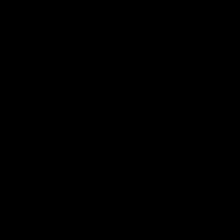

In [53]:
to_pil(c[0].cpu())

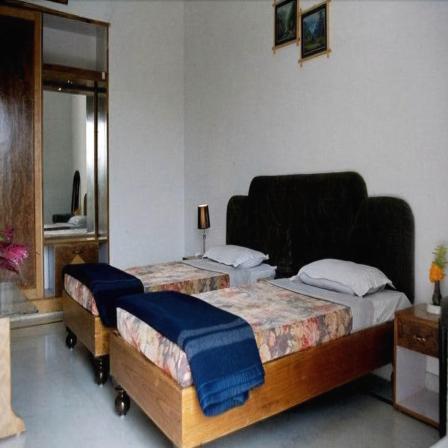

In [54]:
to_pil(s[0].cpu())

In [8]:
%load_ext autoreload
%autoreload 2
from utils import *
from attention_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
to_pil = transforms.ToPILImage(mode='RGB')

In [10]:
label = 'kitchen'

In [11]:
device = 'cuda:1'

In [12]:
model = AttentionModel.load_model(device, 'models/kitchen-0.85/')

In [13]:
batch_size = 16
    
train_data = get_data(label, True)

multitag_data = get_data_multilabel(label)

train_dataset = MultitagDataset('/data/hotel_images/', label, train_data)

test_dataset = MultitagDataset('/data/hotel_images/', label, multitag_data)

images_dataset = MultitagDataset('/data/hotel_images/', label, multitag_data, transform=image_transformations)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images_dataloader = DataLoader(images_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
images = []
for images, labels in images_dat

In [14]:
model.eval_mode()

with torch.no_grad():

    total = .0
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        probs, _ = model.forward(images.to(device), eval_mode=True)
        pred = probs > 0.5
        pred = pred.float().T.detach().cpu().numpy().ravel()
        labels = labels.float().detach().cpu().numpy().ravel()

        y_true.extend(labels.tolist())
        y_pred.extend(pred.tolist())

        label_indices = np.argwhere(pred == 1.0).ravel()
        pred_indices = np.argwhere(labels == 1.0).ravel()


        pred_ones = {*pred_indices} if len(pred_indices) > 0 else set()
        label_ones = {*label_indices} if len(label_indices) > 0 else set()

        good_ones = pred_ones.intersection(label_ones)

        total += len(good_ones)


    acc = balanced_accuracy_score(y_true, y_pred)

    print('multitag accuracy = %s' % str(total))
    print('balanced accuracy = %s' % str(acc))

/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


multitag accuracy = 15.0
balanced accuracy = 0.8510209951107277


In [15]:
images_list = []
for images, labels in images_dataloader:
    images_list.append(images)

In [16]:
model.eval_mode()

with torch.no_grad():
    
    boxes_list = []
    
    for images, labels in test_dataloader:
        attention_maps, attention_crops, ideal_attention_maps, max_centers, boxes = model.get_crops_forward(images.to(device))
        boxes_list.append(boxes)


In [17]:
att1_boxes = torch.cat([m['att1'] for m in boxes_list])

In [18]:
att2_boxes = torch.cat([m['att2'] for m in boxes_list])

In [19]:
att3_boxes = torch.cat([m['att3'] for m in boxes_list])

In [20]:
att4_boxes = torch.cat([m['att4'] for m in boxes_list])

In [21]:
images = torch.cat(images_list).to(device)

In [22]:
att1_crops = model.take_crops(att1_boxes, images)

In [23]:
att2_crops = model.take_crops(att2_boxes, images)

In [24]:
att3_crops = model.take_crops(att3_boxes, images)

In [25]:
att4_crops = model.take_crops(att4_boxes, images)

In [26]:
import matplotlib.pyplot as ptl

In [27]:
np.argwhere(np.array(y_true) == 1.0).ravel()

array([ 17,  22,  26,  28,  30,  38,  45,  61,  77,  88,  94, 107, 111,
       115, 116, 123, 154, 159, 192])

In [169]:
idx = 192

In [170]:
y_pred[idx]

1.0

In [171]:
y_true[idx]

1.0

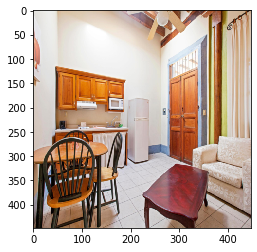

In [172]:
plt.imshow(to_pil(images[idx].cpu()))

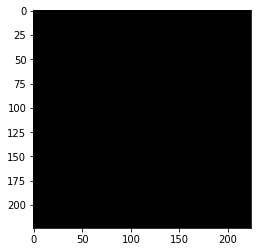

In [173]:
plt.imshow(to_pil(att1_crops[idx].cpu()))

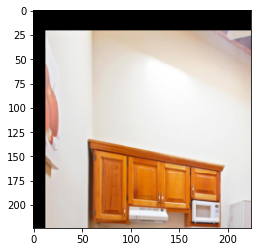

In [174]:
plt.imshow(to_pil(att2_crops[idx].cpu()))

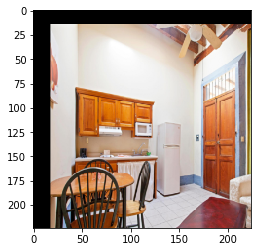

In [175]:
plt.imshow(to_pil(att3_crops[idx].cpu()))

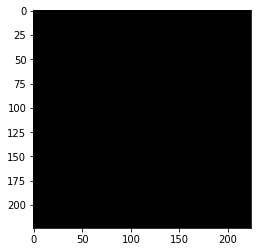

In [168]:
plt.imshow(to_pil(att4_crops[idx].cpu()))